# Proyek Klasifikasi Gambar: [Hewan 'Cat', 'Wild'. 'Dog']
- **Nama:** [Rangga Aditya Pradana]
- **Email:** [pradanaaditya@gmail.com]
- **ID Dicoding:** [M331D5Y1649]

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install -q tensorflow tensorflowjs scikit-learn

import os, zipfile, shutil, pathlib, time
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras import layers, models, callbacks, optimizers

print("TensorFlow version:", tf.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2025.10.1 requires packaging>=24.1, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.38.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
TensorFlow version: 2.19.0


## Data Preparation

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data Loading

In [3]:
# Path ZIP di Google Drive
zip_path = "/content/drive/MyDrive/Submission/archive (2).zip"

# Folder hasil ekstraksi
extract_dir = "/content/sample_data/hewan"

# Ekstrak ZIP
if not os.path.exists(extract_dir):
    print("Ekstraksi dataset...")
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(extract_dir)
    print("Ekstraksi selesai di:", extract_dir)
else:
    print("Dataset sudah diekstrak di:", extract_dir)

print("Isi folder:", os.listdir(extract_dir))

# Simpan path ke variabel utama
DATA_DIR = extract_dir

Ekstraksi dataset...
Ekstraksi selesai di: /content/sample_data/hewan
Isi folder: ['cat', 'wild', 'dog']


#### Split Dataset

In [4]:
import os, shutil, random
from pathlib import Path

# CONFIG: ubah kalau perlu
SRC_DIR = "/content/sample_data/hewan"
DEST_DIR = "/content/sample_data/hewan_split"
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
RANDOM_SEED = 42
IMAGE_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".gif"}

random.seed(RANDOM_SEED)

def find_class_folders(src_dir):
    p = Path(src_dir)
    classes = [d for d in p.iterdir() if d.is_dir()]
    # If there's a nested folder with same name as root, flatten suggestion won't be handled here.
    return [c.name for c in classes]

# 1) Pastikan SRC_DIR ada
if not os.path.exists(SRC_DIR):
    raise FileNotFoundError(f"SRC_DIR tidak ditemukan: {SRC_DIR}")

# 2) Dapatkan list kelas (subfolders)
class_folders = [d for d in os.listdir(SRC_DIR) if os.path.isdir(os.path.join(SRC_DIR, d))]
if len(class_folders) == 0:
    raise ValueError(f"Tidak ditemukan subfolder kelas di {SRC_DIR}. Pastikan struktur: {SRC_DIR}/<class>/*")

print("Ditemukan kelas:", class_folders)

# 3) Buat folder tujuan (train/val/test/class)
for subset in ("train", "val", "test"):
    for cls in class_folders:
        out_dir = os.path.join(DEST_DIR, subset, cls)
        os.makedirs(out_dir, exist_ok=True)

# 4) Untuk setiap kelas, ambil semua file gambar, shuffle, split dan copy
summary = {}
for cls in class_folders:
    src_cls_dir = os.path.join(SRC_DIR, cls)
    all_files = [os.path.join(src_cls_dir, f) for f in os.listdir(src_cls_dir)
                 if os.path.isfile(os.path.join(src_cls_dir, f)) and Path(f).suffix.lower() in IMAGE_EXTS]
    all_files.sort()  # deterministic before shuffle
    random.shuffle(all_files)
    n = len(all_files)
    if n == 0:
        print(f"⚠️ Peringatan: kelas '{cls}' kosong (tidak ada file gambar). Lewati.")
        continue

    n_train = int(n * TRAIN_RATIO)
    n_val = int(n * VAL_RATIO)
    # remainder to test
    n_test = n - n_train - n_val

    train_files = all_files[:n_train]
    val_files = all_files[n_train:n_train + n_val]
    test_files = all_files[n_train + n_val:]

    # jika rounding membuat salah (mis. n_test == 0), atur minimal 1 contoh di tiap subset jika memungkinkan
    # (opsional, hapus jika tidak diinginkan)
    if len(val_files) == 0 and n >= 3:
        # pindahkan 1 dari train ke val
        val_files = train_files[-1:]
        train_files = train_files[:-1]
    if len(test_files) == 0 and n >= 3:
        test_files = train_files[-1:]
        train_files = train_files[:-1]

    # copy files
    for f in train_files:
        shutil.copy(f, os.path.join(DEST_DIR, "train", cls, os.path.basename(f)))
    for f in val_files:
        shutil.copy(f, os.path.join(DEST_DIR, "val", cls, os.path.basename(f)))
    for f in test_files:
        shutil.copy(f, os.path.join(DEST_DIR, "test", cls, os.path.basename(f)))

    summary[cls] = {
        "total": n,
        "train": len(train_files),
        "val": len(val_files),
        "test": len(test_files)
    }

# 5) Tampilkan ringkasan
print("\n=== Split selesai ===")
total_all = 0
for cls, info in summary.items():
    total_all += info["total"]
    print(f"Kelas '{cls}': total={info['total']}, train={info['train']}, val={info['val']}, test={info['test']}")
print("Total semua gambar:", total_all)
print("Folder output:", DEST_DIR)

# 6) Cek cepat isi folder (opsional)
print("\nContoh isi folder hasil (depan):")
for subset in ("train", "val", "test"):
    samp = []
    for cls in class_folders:
        p = os.path.join(DEST_DIR, subset, cls)
        cnt = len([x for x in os.listdir(p) if Path(x).suffix.lower() in IMAGE_EXTS])
        samp.append(f"{cls}:{cnt}")
    print(f"{subset}: " + ", ".join(samp))

# 7) Petunjuk: pakai DEST_DIR sebagai folder untuk image_dataset_from_directory
print(f"\nSekarang kamu bisa load dataset fisik dari: {DEST_DIR}")
print("Contoh:")
print("ds_train = image_dataset_from_directory('/content/sample_data/hewan_split/train', ...)")

Ditemukan kelas: ['cat', 'wild', 'dog']

=== Split selesai ===
Kelas 'cat': total=5558, train=4446, val=555, test=557
Kelas 'wild': total=5076, train=4060, val=507, test=509
Kelas 'dog': total=5169, train=4135, val=516, test=518
Total semua gambar: 15803
Folder output: /content/sample_data/hewan_split

Contoh isi folder hasil (depan):
train: cat:4446, wild:4060, dog:4135
val: cat:555, wild:507, dog:516
test: cat:557, wild:509, dog:518

Sekarang kamu bisa load dataset fisik dari: /content/sample_data/hewan_split
Contoh:
ds_train = image_dataset_from_directory('/content/sample_data/hewan_split/train', ...)


### Data Preprocessing

In [5]:
# 📂 Load Dataset Fisik (train / val / test)
from tensorflow.keras.preprocessing import image_dataset_from_directory

DATA_DIR = "/content/sample_data/hewan_split"

ds_train_raw = image_dataset_from_directory(
    os.path.join(DATA_DIR, "train"),
    labels='inferred',
    label_mode='int',
    image_size=(128, 128),
    batch_size=64,
    shuffle=True,
    seed=42
)

ds_val_raw = image_dataset_from_directory(
    os.path.join(DATA_DIR, "val"),
    labels='inferred',
    label_mode='int',
    image_size=(128, 128),
    batch_size=64,
    shuffle=False,
    seed=42
)

ds_test_raw = image_dataset_from_directory(
    os.path.join(DATA_DIR, "test"),
    labels='inferred',
    label_mode='int',
    image_size=(128, 128),
    batch_size=64,
    shuffle=False,
    seed=42
)

class_names = ds_train_raw.class_names
num_classes = len(class_names)
print(f"Jumlah kelas: {num_classes}")
print("Nama kelas:", class_names)

Found 12641 files belonging to 3 classes.
Found 1578 files belonging to 3 classes.
Found 1584 files belonging to 3 classes.
Jumlah kelas: 3
Nama kelas: ['cat', 'dog', 'wild']


In [6]:
# 🧩 Preprocessing & Augmentasi
IMG_SIZE = (128, 128)
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE
SEED = 42

def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
    layers.RandomContrast(0.08),
])

In [7]:
# Terapkan preprocess dan augmentasi
ds_train = ds_train_raw.map(preprocess, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.map(lambda x, y: (data_augmentation(x, training=True), y))
ds_train = ds_train.prefetch(AUTOTUNE)

ds_val = ds_val_raw.map(preprocess, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
ds_test = ds_test_raw.map(preprocess, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

print("✅ Dataset train/val/test siap digunakan.")

✅ Dataset train/val/test siap digunakan.


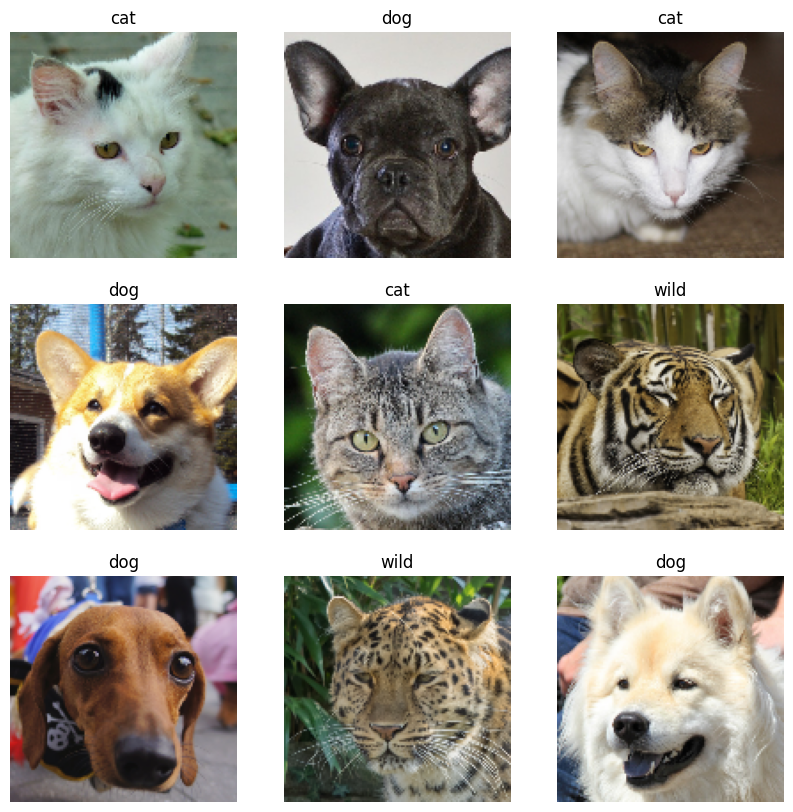

In [8]:
# Visualisasi 9 gambar pertama dari train set
import matplotlib.pyplot as plt

for images, labels in ds_train_raw.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    break

## Modelling

In [9]:
# Training Model
def make_model(input_shape=(*IMG_SIZE, 3), num_classes=num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),

        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),

        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = make_model()
model.summary()

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,482,883 (32.36 MB)

 Trainable params: 8,482,883 (32.36 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# 🧭 Training dengan Callbacks
checkpoint_cb = callbacks.ModelCheckpoint(
    "best_model.h5",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max"
)

earlystop_cb = callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=6,
    restore_best_weights=True
)

reduce_lr_cb = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-7
)

EPOCHS = 30

history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb]
)

Epoch 1/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - accuracy: 0.5180 - loss: 0.9576

198/198 ━━━━━━━━━━━━━━━━━━━━ 162s 750ms/step - accuracy: 0.5186 - loss: 0.9567 - val_accuracy: 0.7820 - val_loss: 0.5165 - learning_rate: 1.0000e-04
Epoch 2/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.8231 - loss: 0.4765

198/198 ━━━━━━━━━━━━━━━━━━━━ 144s 725ms/step - accuracy: 0.8231 - loss: 0.4763 - val_accuracy: 0.8790 - val_loss: 0.3306 - learning_rate: 1.0000e-04
Epoch 3/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 150s 758ms/step - accuracy: 0.8631 - loss: 0.3638 - val_accuracy: 0.8226 - val_loss: 0.4541 - learning_rate: 1.0000e-04
Epoch 4/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - accuracy: 0.8895 - loss: 0.3011

198/198 ━━━━━━━━━━━━━━━━━━━━ 142s 718ms/step - accuracy: 0.8895 - loss: 0.3011 - val_accuracy: 0.8910 - val_loss: 0.2821 - learning_rate: 1.0000e-04
Epoch 5/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 144s 726ms/step - accuracy: 0.9039 - loss: 0.2648 - val_accuracy: 0.8676 - val_loss: 0.3242 - learning_rate: 1.0000e-04
Epoch 6/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.9054 - loss: 0.2492

198/198 ━━━━━━━━━━━━━━━━━━━━ 142s 714ms/step - accuracy: 0.9054 - loss: 0.2492 - val_accuracy: 0.9303 - val_loss: 0.1957 - learning_rate: 1.0000e-04
Epoch 7/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 143s 716ms/step - accuracy: 0.9193 - loss: 0.2220 - val_accuracy: 0.8967 - val_loss: 0.2652 - learning_rate: 1.0000e-04
Epoch 8/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 141s 709ms/step - accuracy: 0.9243 - loss: 0.2044 - val_accuracy: 0.9087 - val_loss: 0.2423 - learning_rate: 1.0000e-04
Epoch 9/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.9365 - loss: 0.1796

198/198 ━━━━━━━━━━━━━━━━━━━━ 142s 713ms/step - accuracy: 0.9365 - loss: 0.1796 - val_accuracy: 0.9449 - val_loss: 0.1636 - learning_rate: 1.0000e-04
Epoch 10/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 138s 695ms/step - accuracy: 0.9342 - loss: 0.1798 - val_accuracy: 0.9392 - val_loss: 0.1713 - learning_rate: 1.0000e-04
Epoch 11/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 134s 676ms/step - accuracy: 0.9443 - loss: 0.1623 - val_accuracy: 0.9398 - val_loss: 0.1646 - learning_rate: 1.0000e-04
Epoch 12/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 142s 674ms/step - accuracy: 0.9450 - loss: 0.1578 - val_accuracy: 0.9240 - val_loss: 0.2185 - learning_rate: 1.0000e-04
Epoch 13/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.9542 - loss: 0.1336

198/198 ━━━━━━━━━━━━━━━━━━━━ 145s 693ms/step - accuracy: 0.9542 - loss: 0.1335 - val_accuracy: 0.9582 - val_loss: 0.1213 - learning_rate: 5.0000e-05
Epoch 14/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 139s 700ms/step - accuracy: 0.9541 - loss: 0.1314 - val_accuracy: 0.9379 - val_loss: 0.1660 - learning_rate: 5.0000e-05
Epoch 15/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 141s 711ms/step - accuracy: 0.9576 - loss: 0.1186 - val_accuracy: 0.9525 - val_loss: 0.1369 - learning_rate: 5.0000e-05
Epoch 16/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 128s 645ms/step - accuracy: 0.9536 - loss: 0.1321 - val_accuracy: 0.9518 - val_loss: 0.1406 - learning_rate: 5.0000e-05
Epoch 17/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 131s 661ms/step - accuracy: 0.9586 - loss: 0.1159 - val_accuracy: 0.9582 - val_loss: 0.1265 - learning_rate: 2.5000e-05
Epoch 18/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 123s 620ms/step - accuracy: 0.9617 - loss: 0.1088 - val_accuracy: 0.9563 - val_loss: 0.1222 - learning_rate: 2.5000e-05
Epoch 19/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 122s 

## Evaluasi dan Visualisasi

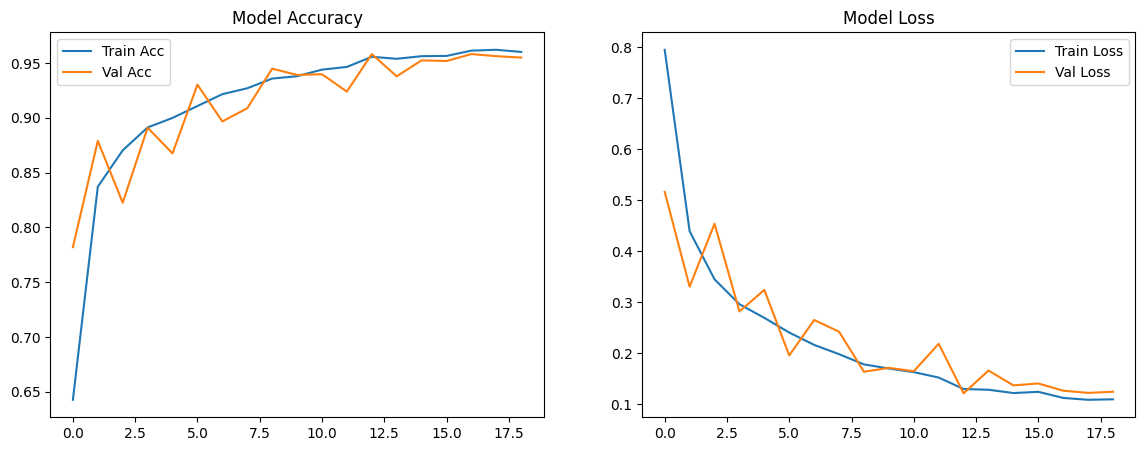

25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 605ms/step - accuracy: 0.9724 - loss: 0.0694
✅ Test Accuracy: 0.9615
✅ Test Loss: 0.0997


In [11]:
def plot_history(h):
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(h.history['accuracy'], label='Train Acc')
    plt.plot(h.history['val_accuracy'], label='Val Acc')
    plt.title('Model Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(h.history['loss'], label='Train Loss')
    plt.plot(h.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.legend()
    plt.show()

plot_history(history)

test_loss, test_acc = model.evaluate(ds_test)
print(f"✅ Test Accuracy: {test_acc:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step


<Figure size 600x600 with 0 Axes>

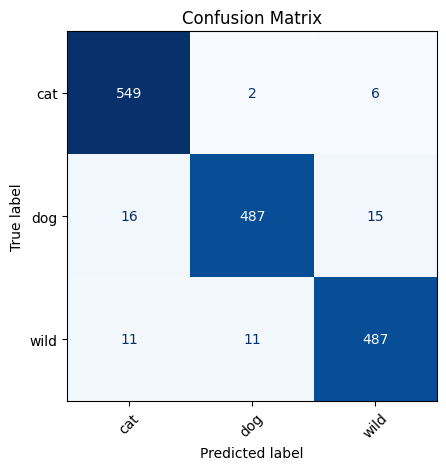

Akurasi kelas 'cat': 98.56%
Akurasi kelas 'dog': 94.02%
Akurasi kelas 'wild': 95.68%


In [12]:
# 🧮 Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Pastikan sudah ada ds_test dan class_names
y_true = []
y_pred = []

# Loop seluruh batch di test set
for images, labels in ds_test:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Ubah ke numpy array
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Tampilkan hasil
plt.figure(figsize=(6,6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45, colorbar=False)
plt.title("Confusion Matrix")
plt.show()

# Akurasi per kelas (opsional)
class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(class_names, class_acc):
    print(f"Akurasi kelas '{cls}': {acc:.2%}")

## Konversi Model

In [13]:
# Simpan Model: Keras (.keras), SavedModel, TFLite (optimized), TFJS
import os
import numpy as np
import tensorflow as tf
import shutil

# Paths
keras_path = "/content/best_model.keras"       # untuk penyimpanan model Keras (file tunggal)
export_savedmodel_dir = "/content/saved_model" # folder SavedModel untuk TFLite/TFJS
tflite_path = "/content/model_opt.tflite"
tfjs_out_dir = "/content/tfjs_model"
drive_out = "/content/drive/MyDrive/Submission/models"  # optional: salin ke Drive

# --- Mount Drive jika Colab ---
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
except Exception:
    pass

# --- Buat folder yang diperlukan ---
os.makedirs(os.path.dirname(keras_path), exist_ok=True)
os.makedirs(export_savedmodel_dir, exist_ok=True)
os.makedirs(os.path.dirname(tflite_path), exist_ok=True)
os.makedirs(tfjs_out_dir, exist_ok=True)
try:
    os.makedirs(drive_out, exist_ok=True)
except Exception:
    pass

# 1) Save as Keras format (.keras)
print("1) Saving model as Keras format (.keras)...")
model.save(keras_path)  # Keras 3 style
print("✅ Keras model saved to:", keras_path)

# 2) Export as SavedModel (for TFLite / TFJS / TF Serving)
print("\n2) Exporting SavedModel for TFLite/TFJS ...")
try:
    # Keras 3 provides model.export
    model.export(export_savedmodel_dir)
    print("✅ model.export() used. SavedModel exported to:", export_savedmodel_dir)
except Exception as e:
    # fallback: use tf.saved_model.save
    print("⚠️ model.export() failed or not available (fallback). Reason:", e)
    print("Using tf.saved_model.save(...) as fallback.")
    tf.saved_model.save(model, export_savedmodel_dir)
    print("✅ SavedModel saved to:", export_savedmodel_dir)

# 3) Convert SavedModel -> TFLite (optimized)
print("\n3) Converting SavedModel -> TFLite (optimized)...")
try:
    converter = tf.lite.TFLiteConverter.from_saved_model(export_savedmodel_dir)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]  # dynamic range quantization
    tflite_model = converter.convert()
    with open(tflite_path, "wb") as f:
        f.write(tflite_model)
    print("✅ TFLite (optimized) saved to:", tflite_path)
except Exception as e:
    print("❌ TFLite conversion failed:", e)

# 4) Basic verify TFLite (if file exists)
print("\n4) Verifying TFLite model (basic)...")
if os.path.exists(tflite_path):
    try:
        interpreter = tf.lite.Interpreter(model_path=tflite_path)
        interpreter.allocate_tensors()
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()
        print("Input details:", input_details)
        print("Output details:", output_details)

        # ambil 1 contoh dari ds_test
        sample_img = None
        try:
            for images, labels in ds_test.take(1):
                sample_img = images[0:1].numpy().astype(np.float32)
                break
        except Exception:
            sample_img = None

        if sample_img is None:
            print("⚠️ ds_test tidak tersedia di namespace atau kosong — lewati verifikasi TFLite.")
        else:
            if input_details[0]['dtype'] == np.int8:
                scale, zero_point = input_details[0]['quantization']
                sample_in = sample_img / scale + zero_point
                sample_in = sample_in.astype(np.int8)
            else:
                sample_in = sample_img.astype(np.float32)

            interpreter.set_tensor(input_details[0]['index'], sample_in)
            interpreter.invoke()
            pred = interpreter.get_tensor(output_details[0]['index'])

            if output_details[0]['dtype'] == np.int8:
                out_scale, out_zero_point = output_details[0]['quantization']
                pred = (pred.astype(np.float32) - out_zero_point) * out_scale

            print("TFLite pred (argmax):", np.argmax(pred, axis=-1))
    except Exception as e:
        print("⚠️ Verifikasi TFLite gagal:", e)
else:
    print("⚠️ File TFLite tidak ditemukan, lewati verifikasi.")

# 5) Convert SavedModel -> TFJS (requires tensorflowjs)
print("\n5) Converting SavedModel -> TFJS (this may take a while)...")
try:
    import tensorflowjs  # noqa
except Exception:
    print("Installing tensorflowjs...")
    !pip install -q tensorflowjs

# Run the conversion command (Colab supports shell)
try:
    # Note: tensorflowjs_converter is a CLI; this will create tfjs_out_dir
    !tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model \
        --signature_name=serving_default --saved_model_tags=serve {export_savedmodel_dir} {tfjs_out_dir}
    print("✅ TFJS model saved to:", tfjs_out_dir)
except Exception as e:
    print("❌ TFJS conversion failed:", e)

# 6) Optional: copy artifacts to Google Drive for persistence
print("\n6) Copying artifacts to Google Drive (if mounted)...")
try:
    if os.path.exists("/content/drive"):
        # copy keras file
        shutil.copy(keras_path, os.path.join(drive_out, os.path.basename(keras_path)))
        # copy saved_model folder
        dst_sm = os.path.join(drive_out, "saved_model")
        if os.path.exists(dst_sm):
            shutil.rmtree(dst_sm)
        shutil.copytree(export_savedmodel_dir, dst_sm)
        # copy tflite
        if os.path.exists(tflite_path):
            shutil.copy(tflite_path, os.path.join(drive_out, os.path.basename(tflite_path)))
        # copy tfjs folder
        dst_tfjs = os.path.join(drive_out, "tfjs_model")
        if os.path.exists(dst_tfjs):
            shutil.rmtree(dst_tfjs)
        if os.path.exists(tfjs_out_dir):
            shutil.copytree(tfjs_out_dir, dst_tfjs)
        print("✅ Artifacts copied to Drive:", drive_out)
    else:
        print("⚠️ Google Drive not mounted; skipping copy-to-Drive.")
except Exception as e:
    print("⚠️ Could not copy to Drive:", e)

print("\n🎉 Semua selesai. Cek folder output di Colab (/content) atau di Drive jika kamu menyalinnya.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1) Saving model as Keras format (.keras)...
✅ Keras model saved to: /content/best_model.keras

2) Exporting SavedModel for TFLite/TFJS ...
Saved artifact at '/content/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_5')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  137369630542928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137369630545808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137369630546768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137369630546000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137369630546384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137369630547728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137369630548688: Ten

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


TFLite pred (argmax): [0]

5) Converting SavedModel -> TFJS (this may take a while)...


2025-11-10 14:15:13.997862: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762784114.271549   14548 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762784114.354313   14548 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762784114.803959   14548 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762784114.803997   14548 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762784114.804002   14548 computation_placer.cc:177] computation placer alr

In [14]:
import os, shutil, numpy as np, tensorflow as tf
from pathlib import Path

SAVEDMODEL_DIR = "/content/saved_model"
KERAS_FILE = "/content/best_model.keras"
# target submission folder structure
SUBMISSION_DIR = "/content/submission"
TFLITE_SUBFOLDER = "tflite"
LABEL_FILENAME = "label.txt"

# names
tflite_target_dir = os.path.join(SUBMISSION_DIR, TFLITE_SUBFOLDER)
tflite_target_path = os.path.join(tflite_target_dir, "model.tflite")
label_target_path = os.path.join(tflite_target_dir, LABEL_FILENAME)

os.makedirs(tflite_target_dir, exist_ok=True)

try:
    class_names  # try to reference
except NameError:
    # coba ambil dari a saved label.txt di root (opsional)
    class_names = None

# ----- 2) jika tidak ada model.tflite, buat dari SavedModel atau .keras -----
if not os.path.exists(tflite_target_path):
    print("model.tflite belum ada di target. Mencari file atau membuat konversi...")

    # prefer convert from SavedModel if exists
    if os.path.exists(SAVEDMODEL_DIR) and os.path.isdir(SAVEDMODEL_DIR):
        print("Menemukan SavedModel di:", SAVEDMODEL_DIR)
        try:
            converter = tf.lite.TFLiteConverter.from_saved_model(SAVEDMODEL_DIR)
            # optional optimization
            converter.optimizations = [tf.lite.Optimize.DEFAULT]
            tflite_model = converter.convert()
            with open(tflite_target_path, "wb") as f:
                f.write(tflite_model)
            print("✅ Berhasil konversi SavedModel -> TFLite di:", tflite_target_path)
        except Exception as e:
            print("❌ Gagal konversi dari SavedModel:", e)
    elif os.path.exists(KERAS_FILE):
        # jika ada .keras: load, export lalu convert
        print("Menemukan .keras file di:", KERAS_FILE)
        try:
            model = tf.keras.models.load_model(KERAS_FILE)
            # export ke temp saved_model dan convert
            tmp_export = "/tmp/tmp_export_savedmodel"
            if os.path.exists(tmp_export):
                shutil.rmtree(tmp_export)
            tf.saved_model.save(model, tmp_export)
            converter = tf.lite.TFLiteConverter.from_saved_model(tmp_export)
            converter.optimizations = [tf.lite.Optimize.DEFAULT]
            tflite_model = converter.convert()
            with open(tflite_target_path, "wb") as f:
                f.write(tflite_model)
            print("✅ Berhasil convert .keras -> SavedModel -> TFLite at:", tflite_target_path)
            # cleanup
            shutil.rmtree(tmp_export)
        except Exception as e:
            print("❌ Gagal convert dari .keras:", e)
    else:
        print("⚠️ Tidak menemukan SavedModel atau .keras untuk dikonversi. Pastikan kamu sudah mengekspor model terlebih dahulu.")
else:
    print("model.tflite sudah ada di target:", tflite_target_path)

# ----- 3) Buat label.txt jika class_names tersedia -----
if class_names is None:
    # coba load label.txt dari possible locations
    possible = [os.path.join(SUBMISSION_DIR,"label.txt"), os.path.join("/content","label.txt")]
    found = False
    for p in possible:
        if os.path.exists(p):
            with open(p, "r") as f:
                class_names = [line.strip() for line in f.readlines() if line.strip()]
            print("Label loaded from", p)
            found = True
            break
    if not found:
        print("class_names tidak tersedia. Jika kamu ingin membuat label.txt, buat list manual class_names = ['cat','dog','wild']")
else:
    print("class_names tersedia, akan membuat label.txt di submission.")

if class_names:
    try:
        with open(label_target_path, "w") as f:
            for c in class_names:
                f.write(f"{c}\n")
        print("✅ label.txt dibuat di:", label_target_path)
    except Exception as e:
        print("❌ Gagal menulis label.txt:", e)

# ----- 4) Verifikasi isi submission dir -----
print("\n== Struktur submission (preview) ==")
for root, dirs, files in os.walk(SUBMISSION_DIR):
    level = root.replace(SUBMISSION_DIR, "").count(os.sep)
    indent = " " * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = " " * 2 * (level + 1)
    for f in files:
        print(f"{subindent}{f}")
    # limit depth to avoid long output
    if level >= 2:
        continue

model.tflite belum ada di target. Mencari file atau membuat konversi...
Menemukan SavedModel di: /content/saved_model
✅ Berhasil konversi SavedModel -> TFLite di: /content/submission/tflite/model.tflite
class_names tersedia, akan membuat label.txt di submission.
✅ label.txt dibuat di: /content/submission/tflite/label.txt

== Struktur submission (preview) ==
submission/
  tflite/
    model.tflite
    label.txt


In [15]:
 pip freeze requirements.txt

absl-py==1.4.0
absolufy-imports==0.3.1
accelerate==1.11.0
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.13.2
aiosignal==1.4.0
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.2
alembic==1.17.1
altair==5.5.0
annotated-doc==0.0.3
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.11.0
anywidget==0.9.18
argon2-cffi==25.1.0
argon2-cffi-bindings==25.1.0
array_record==0.8.2
arrow==1.4.0
arviz==0.22.0
astropy==7.1.1
astropy-iers-data==0.2025.11.3.0.38.37
astunparse==1.6.3
atpublic==5.1
attrs==25.4.0
audioread==3.1.0
Authlib==1.6.5
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
beartype==0.22.5
beautifulsoup4==4.13.5
betterproto==2.0.0b6
bigframes==2.28.0
bigquery-magics==0.10.3
bleach==6.3.0
blinker==1.9.0
blis==1.3.0
blobfile==3.1.0
blosc2==3.11.0
bokeh==3.7.3
Bottleneck==1.4.2
bqplot==0.12.45
branca==0.8.2
Brotli==1.1.0
build==1.3.0
CacheControl==0.14.3
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.10.5
cffi==2.0.0
chardet==5.2.0
charset-normalizer==3

## Inference (Optional)

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


✅ Loaded model from /content/best_model.keras

🔍 Melakukan prediksi pada contoh dari ds_test...

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


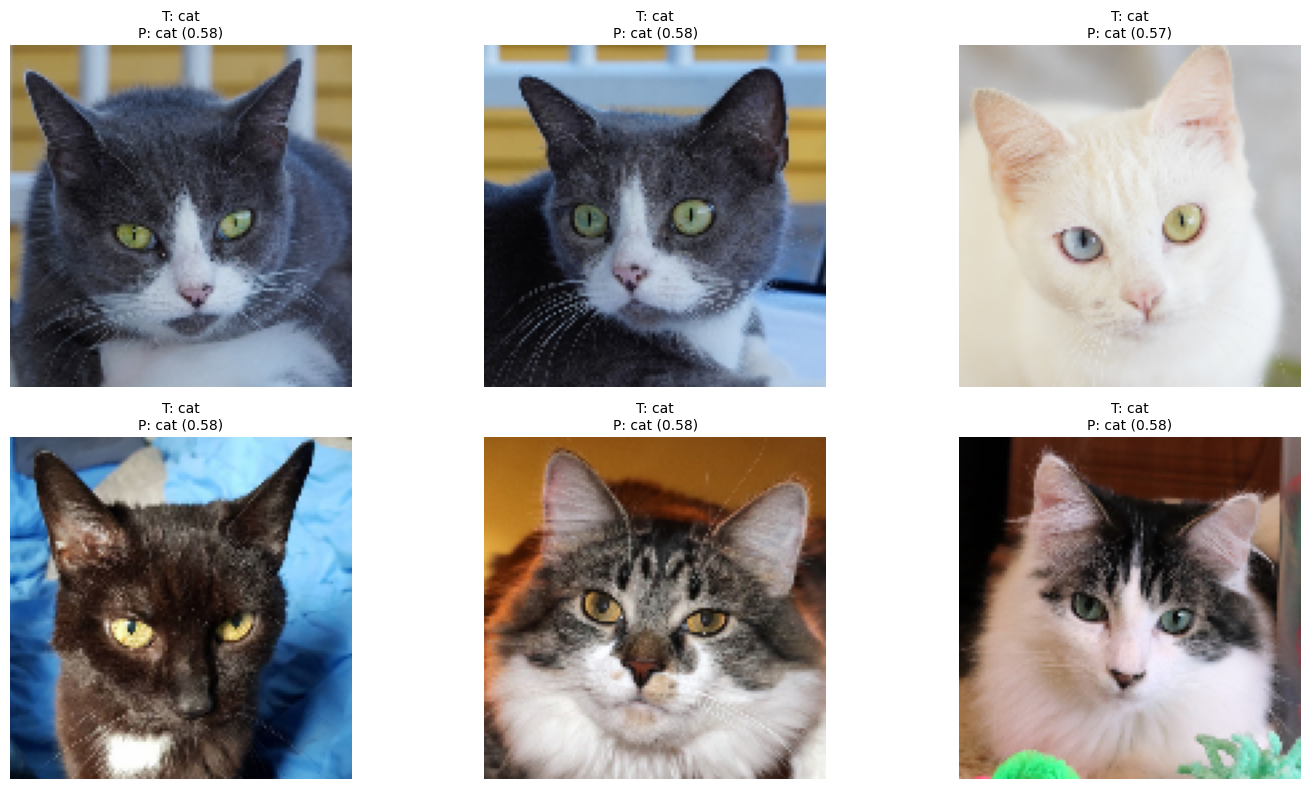


✅ Inference selesai! Hasil disimpan di folder: /content/inference_results


In [16]:
# 🧠 Inference & Visualisasi Langsung di Notebook
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

# Path dan konfigurasi
keras_path = "/content/best_model.keras"       # prefer .keras model
saved_model_dir = "/content/saved_model"       # fallback: SavedModel
out_folder = "/content/inference_results"      # folder untuk bukti
n_show = 6                                     # jumlah contoh tampil

os.makedirs(out_folder, exist_ok=True)

# --- Ambil contoh dari ds_test ---
examples, true_labels = [], []
for images, labels in ds_test.take(1):
    images_np, labels_np = images.numpy(), labels.numpy()
    for i in range(min(n_show, images_np.shape[0])):
        examples.append(images_np[i])
        true_labels.append(int(labels_np[i]))
    break

# --- Load model ---
model_loaded = None
try:
    if os.path.exists(keras_path):
        model_loaded = tf.keras.models.load_model(keras_path)
        print(f"✅ Loaded model from {keras_path}")
    else:
        print("⚠️ File .keras tidak ditemukan, mencoba load SavedModel...")
        model_loaded = tf.saved_model.load(saved_model_dir)
        infer_fn = model_loaded.signatures["serving_default"]
except Exception as e:
    print("❌ Gagal load model:", e)

# --- Inference ---
results = []
if model_loaded is not None:
    print("\n🔍 Melakukan prediksi pada contoh dari ds_test...\n")

    plt.figure(figsize=(15, 8))
    for i, img in enumerate(examples):
        inp = img[None, ...].astype(np.float32)
        if isinstance(model_loaded, tf.keras.Model):
            preds = model_loaded.predict(inp)
        else:
            out = infer_fn(tf.constant(inp))
            preds = list(out.values())[0].numpy()

        pred_idx = np.argmax(preds, axis=1)[0]
        conf = float(np.max(tf.nn.softmax(preds)))
        true_name = class_names[true_labels[i]]
        pred_name = class_names[pred_idx]

        results.append({
            "true": true_name,
            "pred": pred_name,
            "conf": conf
        })

        # --- tampilkan gambar langsung ---
        plt.subplot(2, 3, i + 1)
        plt.imshow((img * 255).astype("uint8"))
        plt.title(f"T: {true_name}\nP: {pred_name} ({conf:.2f})", fontsize=10)
        plt.axis("off")

        # --- simpan ke file ---
        plt.imsave(
            os.path.join(out_folder, f"infer_{i}_{true_name}_{pred_name}.png"),
            (img * 255).astype("uint8")
        )

    plt.tight_layout()
    plt.show()

    # --- simpan CSV hasil ---
    pd.DataFrame(results).to_csv(
        os.path.join(out_folder, "inference_results.csv"), index=False
    )

    print(f"\n✅ Inference selesai! Hasil disimpan di folder: {out_folder}")
else:
    print("❌ Tidak ada model yang berhasil dimuat untuk inference.")